# Predicting the Presence of West Nile with Logistic Regression

Here, we present our methods for predicting the presence of West Nile found in mosquito traps.  We first clean our weather and training datasets before merging them.  The preprocessing steps are simply written in a series of functions, though since they were originally written as calling on each other, these are listed logically in reverse order so that they may exist before their respective calls.  The data for the odd years between 2007 and 2013 are used to train a logistic model, validated on a set held out from those same years, and tested on data for the even years between 2008 to 2014.  Final model selection is based on the ROC AUC metric.

## Processing the Training Datasets

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

In [2]:
train = pd.read_csv('../data/train.csv', parse_dates=[0], index_col=0)

Here, we format the training set (odd years) to follow the format of the final test set (even years).  All rows for a single address were combined into a single row which combined number of mosquitos caught and whether the virus was found in any of the vials.  It was also found that two pairs of addresses were labelled as the same trap; the addresses are unique, however, so we just drop the trap ID column.

In [3]:
def combine_rows(df):
    place_table = df[[
        'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy'
    ]].drop_duplicates().set_index(['Address'])

    totals = df.groupby([df.index, 'Trap', 'Address', 'Species']).NumMosquitos.sum()
    has_nile = df.groupby([df.index, 'Trap', 'Address', 'Species']).WnvPresent.sum().map(lambda x: int(x > 0))
    return pd.concat([totals, has_nile], axis=1).reset_index().merge(place_table.drop('Trap', axis=1), on='Address').set_index('Date')

The next four cells detail the process of how to append weather data to the original training data.  Each trap simply takes on the measurements of the nearest weather station.

In [4]:
def deal_w_stations(df2, weather):
    station1Lat = 41.995
    station1Lon = -87.933
    station2Lat = 41.786
    station2Lon = -87.752

    dist1 = abs((df2.Latitude - station1Lat)*1j + (df2.Longitude - station1Lon))
    dist2 = abs((df2.Latitude - station2Lat)*1j + (df2.Longitude - station2Lon))
    compare = dist1 < dist2
    weather_fields = weather.select_dtypes([float,int]).columns[1:]

    for field in weather_fields:
        df2[field] = df2[field + '_x']*compare + df2[field + '_y']*(1-compare)

    redundant_cols = [name for name in df2.columns if '_' in name]

    return df2.drop(redundant_cols, axis=1)

The number of days the weather data was chosen to lag behind the trap collection date was empirically found.  The temperature was initially dropped out altogether in favor of using month and year as features, but were added back in later when a 21 day shift for the remaining columns was shown to increase the score of the model, though adjusted separately.  The result is simply noted here that changing the default day lag to 21 days was single-handedly the largest factor in model performance, and this point is discussed a bit further in the concluding remarks.  

In [5]:
shift_dict_default = {
        'Tmin':7,
        'Tmax':7,
        'Tavg':7,
        'sundiff':31
}

In [6]:
def weatherShiftLogic(col, shift_dict=shift_dict_default):
    if col.name in shift_dict:
        return col.shift(shift_dict[col.name])
    else:
        return col.shift(21)

Information on heating and cooling, sunrise and sunset are combined into single columns in an effort to reduce the features needed in the model.  This is done to reduce the possibility of needless underfitting during regularization.  isRain is also dropped, since a day-shift configuration where it doesn't simply introduce noise was not found.

In [7]:
def merge_weather(df):
    weather = pd.read_csv('../data/ps_weather_processed.csv', parse_dates=[0], index_col=0)\
                .apply(lambda col: col.replace('-',None).ffill().astype(int) if col.name in ['Sunrise', 'Sunset'] else col)\
                .assign(HCDiff = lambda df: df.Heat - df.Cool, sundiff = lambda df: df.Sunset - df.Sunrise)\
                .drop(['Heat', 'Cool', 'isRain', 'Sunrise', 'Sunset'], axis=1)

    a = weather.query('Station==1').drop('Station', axis=1).select_dtypes([float,int]).apply(weatherShiftLogic)
    b = weather.query('Station==2').drop('Station', axis=1).select_dtypes([float,int]).apply(weatherShiftLogic)
    df = df.join([a, b]).dropna()
    return deal_w_stations(df, weather)

Finally, we introduce month and year as features, as well as squared terms to allow the model to detect a maximum probability of finding West Nile in August, a minimum in the year 2009, and maxima at the extremes of latitude and longitude listed in the dataset.  These are introduced to increase the accuracy of the model; though these are artificial and should not arbitrarily be used to extrapolate to data outside the limits considered in the training data, we introduce these to fit at least to the extrema mentioned.  The variable 'none' encapsulates any species that does not carry West Nile, though vials listed as 'unlabeled' in the even years dataset are not included.

In [8]:
def adjust_columns(df):
    relevant_species = ['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS']
    for species in relevant_species:
        df[species] = df.Species.map(lambda x: int(x==species))
    df = df.assign(
        none=df.Species.map(lambda x: int(x not in relevant_species and x not in 'UNSPECIFIED CULEX')), 
        month = df.index.month, 
        lat2 = df.Latitude**2, 
        lon2 = df.Longitude**2,
        month2 = df.index.month**2,
        year = df.index.year, 
        year2 = df.index.year**2,
        Tavg2 = df.Tavg**2,
        Tmin2 = df.Tmin**2,
        Tmax2 = df.Tmax**2
    )
    df = df.select_dtypes([int, float]).drop(['Block', 'AddressAccuracy'], axis=1)
    return df

Finally, the minority class will be bootstrapped for the training data.  The different species among the carriers are not equally represented, however.

In [9]:
def naivestrap(x, y):
    positive_index = y.reset_index().query('WnvPresent==1').index
    indices = np.random.choice(positive_index, size=len(y)-y.sum())
    return x.copy().iloc[indices,:], y.copy().iloc[indices]

In [10]:
df2 = combine_rows(train)

In [11]:
df2 = merge_weather(df2)

In [12]:
df2 = adjust_columns(df2)

## Logistic Regression

A logistic regression model is fit here.  The normal train/test split is used - month and year were introduced to create a polynomial fit to the entire length of time in the dataset, so creating something like a time series split would be counter productive to this end.  However, relaxing the regularization by increasting the parameter C only increases scores across the board for train and test sets.  While this is evidence that we are overfitting to this set of years, all models explored thus far have exhibited the same behavior, except that the CART based models have always shown a much larger discrepancy in accuracy and have also been consistently higher than the even years data in terms of ROC AUC scores.  The polynomial fit solution is then deemed the better solution and presented for further analysis.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

In [14]:
np.random.seed(0)
x = df2.drop(['WnvPresent','NumMosquitos'], axis=1)
y = df2.WnvPresent

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3)

In [15]:
xtrainint, ytrainint = naivestrap(xtrain, ytrain)
xtrain = pd.concat([xtrain, xtrainint])
ytrain = pd.concat([ytrain, ytrainint])

In [16]:
scaler = StandardScaler()

In [17]:
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [18]:
logreg = LogisticRegression(C=.1, penalty='l2')
logreg.fit(xtrain, ytrain)
logreg.score(xtrain, ytrain)

0.7562901266701371

In [19]:
logreg.score(xtest, ytest)

0.6773175542406311

In [20]:
roc_auc_score(ytrain, [proba[1] for proba in logreg.predict_proba(xtrain)])

0.8210615755520682

In [21]:
roc_auc_score(ytest, [proba[1] for proba in logreg.predict_proba(xtest)])

0.8050383321534603

The accuracy difference between the train and test sets tell us that the model is overfit to its training data.  However, the ROC AUC scores being similar reveal that there can be some balanced threshold that allows us to strike a balance in the true and false positive rates, or indirectly and perhaps more relevant to our problem, between false negatives and false positives.  This will be discussed further, but we should first note the coefficients of our model.

In [22]:
sorted(list(zip(x.columns, logreg.coef_[0])), key=lambda x: abs(x[1]), reverse=True)

[('month', 1.3650810074714608),
 ('StnPressure', -1.116900314190066),
 ('SeaLevel', 1.0759285454166625),
 ('sundiff', 1.0093328471282068),
 ('HCDiff', -0.9344320626107855),
 ('Tavg', 0.8014792883363042),
 ('none', -0.6792028372246097),
 ('Tmax2', -0.6556811910118512),
 ('DewPoint', -0.6188189508500257),
 ('Tmin2', -0.3753983325783691),
 ('year2', 0.27066630972158795),
 ('CULEX PIPIENS', 0.2583045648512097),
 ('Tavg2', 0.2493368573336122),
 ('year', 0.241148900837673),
 ('CULEX RESTUANS', -0.2219969167345034),
 ('WetBulb', 0.20139253468594154),
 ('lon2', 0.17670703041604188),
 ('Longitude', -0.1696833067605617),
 ('Latitude', -0.15463066035525327),
 ('Tmin', 0.13438216148986193),
 ('CULEX PIPIENS/RESTUANS', 0.123893138615133),
 ('Tmax', -0.12012795061709881),
 ('lat2', -0.1190621331454187),
 ('ResultDir', 0.10944471594206717),
 ('month2', -0.06489810999637328),
 ('AvgSpeed', 0.06417743054956461),
 ('ResultSpeed', -0.05731566146094226),
 ('PrecipTotal', 0.046169800844314275)]

Many of the coefficients behave as intended; the $month^2$ and $temperature^2$ coefficients are negative, emulating a peak value.  The coefficients for year and $year^2$ are on the same order and both positive, emulating the lack of West Nile in 2009 and resurgence since, though this effect is relatively weak.  $Longitude^2$ being positive also emulates the lack of West Nile between the airport and the lake further south.  It is surprising that $latitude^2$ is negative, though it is a small effect, along with $latitude$ itself.  We should note that there are many days where West Nile is present in one corner but not the other; it was unfair to say that the spatial dependence was independent of the temporal, nor did this model consider when each species tends to bloom.

It should be noted that removing the squared terms did not have much of an effect on the final metric scores.  Though the quadratics would capture extrema, it is not guaranteed to be more accurate on average.

## Testing Against Years Held Out

We test our model against the even years between 2008 to 2014 now.  The final ROC AUC score is reported as 0.813 with the current seed and settings, somewhere between the training and testing scores obtained.  We cannot, however, examine the actual errors in this dataset - we simply note the consistency in score between sets to show our model as generalizable to these years previously missing.

In [24]:
test = pd.read_csv('../data/test.csv', parse_dates=[1], index_col=1)

In [26]:
test = merge_weather(test)

In [27]:
test = adjust_columns(test)

In [28]:
test = test.drop('Id', axis=1)

In [29]:
test = scaler.transform(test)

In [30]:
submission = pd.DataFrame([predictions[1] for predictions in logreg.predict_proba(test)], columns=['WnvPresent'])
submission = submission.reset_index().rename({'index':'Id'}, axis=1)
submission.loc[:,'Id'] = submission.Id + 1
submission = submission.set_index('Id')
submission.to_csv('../Kaggle/submissionlog.csv')

## Mispredictions and Choice of Threshold

Ultimately, we must weigh the consequences of misprediction.  We look at the ROC AUC general shape and follow with a discussion of the false positive rate and false negative rate on the test set:

In [31]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
fpr, tpr, th = roc_curve(ytest, [proba[1] for proba in logreg.predict_proba(xtest)])

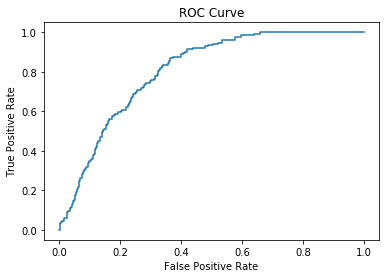

In [33]:
plt.plot(fpr, tpr);
plt.title('ROC Curve');
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');

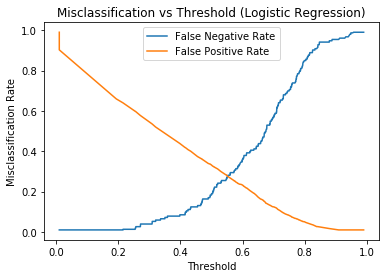

In [34]:
plt.plot(np.clip(th,0.01,0.99), np.clip(1-tpr,0.01,0.99), label='False Negative Rate');
plt.plot(np.clip(th, 0.01, 0.99), np.clip(fpr,0.01,0.99), label='False Positive Rate');
plt.title('Misclassification vs Threshold (Logistic Regression)');
plt.ylabel('Misclassification Rate');
plt.xlabel('Threshold');
plt.legend();

False negatives and false positives are balanced near a threshold of less than 0.6.  A better compromise might be found tracing back from this point to somewhere near 0.4, where we have a false negative rate closer to around 10%, while the false positive rate is above 40%.  Below this, there are diminishing returns in reducing false negatives while false positives continue to increase at the same rate.

# Concluding Remarks

While flawed, this model is preferred to the tree based models explored, which surprisingly could not match the performance of our logistic regression.  As mentioned before, the default time shift for the weather data was the deciding factor in boosting performance well above what was achieved in the tree-based models, even though the trees had this same shift in weather variables.  Rolling averages over weather was considered - the hope was that if an event important for mosquito breeding did not happen an exact amount of days prior, averaging might still capture these events (for instance, being above some temperature threshold).  However, any amount of averaging seemed to decrease scores, though these were only ever done in groups of variables rather than individually.

Though it was argued that the yearly behavior was added to imitate the minimum in the year 2009, the coefficient was relatively small.  Further, it should be reminded that any agreement in this yearly behavior with the years not seen is only by coincidence, since in truth we had no information on mosquito populations or West Nile presence inbetween.  There could be comfort, then, that there is a pattern that appeared independent of years, and that we can make guesses with relatively few false negatives with a limited amount of information a week ahead of time.